**Les bibliothèques**

In [ ]:
# La bibliothèque "__future__" va nous permettre d'activer les comportements (particulièrement dans celles des annatations) des versions futures de Python dans notre version actuelle.
from __future__ import annotations

In [ ]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, binom
from typing import Iterable, Tuple
from re import S


**On écrit deux fonctions pour vérfier si $n$ est bien un entier positif et que $p$ est une probabilité, soit un réel situé dans $[0,1]$.**



1. Fonction pour vérifier si n est un entier positif.

In [ ]:
def _check_int(name : str, value: int, min_inclusive : int=0) -> None: # le _ au début du nom de la fonction indique qu'elle est interne/privée
  if not isinstance(value, (int,np.integer)):
    raise ValueError(f"{name} doit être un entier.")
  if value < min_inclusive:
    raise ValueError(f"{name} doit être >= {min_inclusive}.")

2. Fonction pour vérifier si p est bien dans $[0,1]$

In [ ]:
def _check_prob(p: float) -> float:
    try:
        p = float(p)
    except Exception as e:
      # e contient le message d’erreur original de Python.
        raise ValueError("p doit être convertible en float.") from e
    if p < 0.0 or p > 1.0:
        raise ValueError("p doit être dans [0, 1].")
    return p


**Fonction de simulation d'une loi binomiale**

Cette fonction `simulate_defaults` simule le nombre de défauts dans un portefeuille de `n` prêts, où chaque prêt a une probabilité `p` de défaut.  
L’expérience est répétée `n_sim` fois, ce qui permet d’obtenir un vecteur de réalisations de la loi binomiale.


In [ ]:
def simulate_defaults(n: int, p: float, n_sim: int, rng: np.random.Generator | None = None) -> np.ndarray: # simuler plusieurs fois un portefeuille de prêts, chacun ayant une proba de défaut p.
# chaque simulation donne “combien de défauts” dans ce portefeuille.
    _check_int("n", n, 0)
    _check_int("n_sim", n_sim, 1)
    p = _check_prob(p)
    rng = rng or np.random.default_rng()
    return rng.binomial(n=n, p=p, size=n_sim)

La fonction `summarize_defaults` compare les résultats de la simulation (moyenne, variance, écart-type) avec les valeurs théoriques attendues de la loi binomiale.  
Elle retourne une chaîne de résumé au lieu d’afficher directement, ce qui permet de l’utiliser dans des tests ou de l’enregistrer dans un log.


In [ ]:
def summarize_defaults(sample: np.ndarray, n : int, p: float) -> str:
    _check_int("n", n, 0)
    p = _check_prob(p)
    mu_theo = n * p
    var_theo = n * p * (1 - p)
    mu_emp = float(np.mean(sample))
    var_emp = float(np.var(sample))
    sd_emp  = float(np.std(sample))
    return (
        f"Espérance théorique (n·p): {mu_theo:.3f} | Moyenne observée: {mu_emp:.3f}\n"
        f"Variance théorique (n·p·(1−p)): {var_theo:.3f} | Variance observée: {var_emp:.3f} (écart-type ≈ {sd_emp:.3f})\n"
        f"Interprétation: sur {n} prêts avec PD={p:.2%}, on observe ~{mu_emp:.1f} défauts en moyenne, dispersion ~{sd_emp:.1f}."
    )

**Mesure de la proximité entre Binomiale et Poisson**

Pour évaluer à quel point la loi de Poisson approxime bien la loi binomiale simulée, on calcule la **distance du chi-deux** entre les fréquences observées et les probabilités théoriques attendues.  
La fonction `chi_square_distance` prend en entrée :  
- `empirical_counts` : les effectifs observés (issus de la simulation),  
- `model_probs` : les probabilités du modèle de référence (ex. Poisson),  
et retourne une valeur scalaire :  
- plus la distance est proche de 0, meilleure est l’approximation.


In [ ]:
def chi_square_distance(empirical_counts: np.ndarray, model_probs: np.ndarray) -> float:
    if empirical_counts.shape != model_probs.shape:
        raise ValueError("empirical_counts et model_probs doivent avoir la même shape.")
    total = float(empirical_counts.sum())
    if total <= 0:
        return 0.0
    expected = model_probs * total
    mask = expected >= 1e-9
    observed = empirical_counts[mask]
    expected = expected[mask]
    chi2 = np.sum((observed - expected) ** 2 / (expected + 1e-12))
    return float(chi2 / (total + 1e-12))

**Comparaison Binomiale simulée vs Poisson théorique**

La fonction `compare_binom_poisson` permet de comparer la distribution empirique issue de la simulation d'une loi binomiale $B(n,p)$ avec la loi de Poisson correspondante de paramètre $\lambda = n \cdot p$.  
Elle retourne :  
- la **distance chi²** entre les deux distributions,  
- le support des valeurs (`xs`),  
- les probabilités empiriques simulées (`emp_probs`),  
- les probabilités théoriques de la loi de Poisson (`pois_pmf`).  

Elle peut aussi tracer un graphique qui superpose les deux distributions pour visualiser la qualité de l’approximation.


In [ ]:
def compare_binom_poisson(n: int, p: float, n_sim: int = 30000, show_plot: bool = True, rng: np.random.Generator | None = None) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
    _check_int("n", n, 0)
    _check_int("n_sim", n_sim, 1)
    p = _check_prob(p)
    rng = rng or np.random.default_rng()

    sample = simulate_defaults(n, p, n_sim, rng=rng)
    lam = n * p
    # support autour de la moyenne ± 5*sqrt(λ)
    sd_lam = math.sqrt(max(lam, 1e-9))
    x_min = max(0, int(lam - 5 * sd_lam))
    x_max = int(lam + 5 * sd_lam) + 1
    xs = np.arange(x_min, x_max)

    counts = np.array([np.sum(sample == k) for k in xs])
    emp_probs = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts, dtype=float)
    pois_pmf = poisson.pmf(xs, mu=lam)
    chi2 = chi_square_distance(counts, pois_pmf)

    if show_plot:
        plt.figure()
        plt.bar(xs, emp_probs, width=0.9, align="center", edgecolor="black", label="Binomiale simulée")
        plt.plot(xs, pois_pmf, linewidth=2, label=f"Poisson(λ={lam:.1f})")
        plt.title("Binomiale vs Poisson (événements rares)")
        plt.xlabel("Nombre d'événements (défauts)")
        plt.ylabel("Probabilité")
        plt.legend()
        plt.show()

    return chi2, xs, emp_probs, pois_pmf


**Loi des grands nombres appliquée aux pertes de crédit**

La fonction `lln_convergence` illustre la loi des grands nombres dans un contexte de risque de crédit.  
Chaque prêt a une probabilité de défaut `p`, une exposition `EAD` (Exposure at Default) et une perte en cas de défaut `LGD` (Loss Given Default).  
On simule les défauts pour `N` prêts indépendants, puis on calcule la perte moyenne cumulative au fur et à mesure.  
- Quand `N` augmente, la perte moyenne converge vers sa valeur théorique :  
  $$ \mathbb{E}[\text{perte par prêt}] = p \cdot EAD \cdot LGD $$
- On peut aussi tracer la convergence pour différentes valeurs de `p` afin de tester la sensibilité.


In [ ]:

def lln_convergence(N: int, p: float, EAD: float, LGD: float, ps_for_sensitivity: Iterable[float] | None = None, show_plot: bool = True, rng: np.random.Generator | None = None) -> np.ndarray:
    _check_int("N", N, 1)
    p = _check_prob(p)
    rng = rng or np.random.default_rng()
    loss_unit = EAD * LGD

    def _running_mean_for(pv: float) -> np.ndarray:
        pv = _check_prob(pv)
        defaults = rng.binomial(1, pv, size=N)
        losses = defaults * loss_unit
        return np.cumsum(losses) / np.arange(1, N + 1)

    if show_plot:
        plt.figure()

    rmean_main = _running_mean_for(p)
    if show_plot:
        plt.plot(rmean_main, label=f"p={p}")
        plt.axhline(p * loss_unit, linestyle="--")

    if ps_for_sensitivity:
        for pv in ps_for_sensitivity:
            rmean = _running_mean_for(pv)
            if show_plot:
                plt.plot(rmean, label=f"p={pv}")
                plt.axhline(pv * loss_unit, linestyle="--")

    if show_plot:
        plt.title("Loi des grands nombres — Perte moyenne par prêt")
        plt.xlabel("Nombre de prêts")
        plt.ylabel("Perte moyenne (euros)")
        plt.legend()
        plt.show()

    return rmean_main


**Théorème Central Limite appliqué aux pertes de portefeuille**




La fonction `portfolio_losses` simule la perte totale d’un portefeuille de taille `n`.  
- Chaque prêt a une probabilité de défaut `p`.  
- En cas de défaut, la perte est donnée par `EAD × LGD` (Exposure At Default × Loss Given Default).  
- On répète l’expérience `n_sim` fois pour obtenir une distribution des pertes totales.  

Cette simulation permet d’analyser la variabilité et la distribution des pertes dans un portefeuille de crédit.


In [ ]:
def portfolio_losses(n: int, p: float, EAD: float, LGD: float, n_sim: int, rng: np.random.Generator | None = None) -> np.ndarray:
    """
    Renvoie un array (n_sim,) des pertes totales pour des portefeuilles de taille n.
    """
    _check_int("n", n, 0)
    _check_int("n_sim", n_sim, 1)
    p = _check_prob(p)
    rng = rng or np.random.default_rng()
    loss_unit = EAD * LGD
    defaults = rng.binomial(n=n, p=p, size=n_sim)  # nombre de défauts par portefeuille
    return defaults * loss_unit

La fonction `clt_demo` montre le Théorème Central Limite (TCL) : lorsque la taille du portefeuille `n` augmente, les pertes simulées, une fois normalisées en Z-scores, suivent de plus en plus une loi normale standard $N(0,1)$.


In [ ]:

def clt_demo(ns: Iterable[int], p: float, EAD: float, LGD: float, n_sim: int = 10000, show_plots: bool = True, rng: np.random.Generator | None = None) -> None:
    p = _check_prob(p)
    rng = rng or np.random.default_rng()
    for n in ns:
        L = portfolio_losses(n, p, EAD, LGD, n_sim=n_sim, rng=rng)
        mu = float(np.mean(L))
        sd = float(np.std(L))
        Z = (L - mu) / (sd if sd > 0 else 1.0)
        if show_plots:
            plt.figure()
            plt.hist(Z, bins=30, density=True, edgecolor="black")
            xs = np.linspace(-4, 4, 400)
            plt.plot(xs, norm.pdf(xs), linewidth=2, label="N(0,1)")
            plt.title(f"TCL — Pertes normalisées (n={n})")
            plt.xlabel("Z-score")
            plt.ylabel("Densité")
            plt.legend()
            plt.show()

**Tests rapides (sanity checks)**

La fonction `tests_rapides` effectue quelques vérifications automatiques pour s’assurer que les fonctions de simulation respectent les cas limites et la logique attendue :

- Si `n = 0` ou `p = 0`, aucun défaut ne doit apparaître.  
- Si `p = 1`, tous les prêts doivent défauter.  
- Les pertes doivent être nulles si `p = 0`.  
- L’approximation de la loi de Poisson s’améliore quand `p` devient plus petit.  

Ces assertions permettent de tester rapidement la robustesse du code avant de lancer des simulations plus lourdes.


In [ ]:
def tests_rapides() -> None:
    rng = np.random.default_rng(0)
    assert simulate_defaults(n=0, p=0.3, n_sim=10, rng=rng).sum() == 0
    assert simulate_defaults(n=100, p=0.0, n_sim=100, rng=rng).sum() == 0
    assert (simulate_defaults(n=5, p=1.0, n_sim=10, rng=rng) == 5).all()

    L0 = portfolio_losses(n=100, p=0.0, EAD=100000, LGD=0.5, n_sim=100, rng=rng)
    assert L0.sum() == 0.0

    chi_small, *_ = compare_binom_poisson(n=10000, p=0.001, n_sim=20000, show_plot=False, rng=rng)
    chi_big,   *_ = compare_binom_poisson(n=10000, p=0.01,  n_sim=20000, show_plot=False, rng=rng)
    assert chi_small < chi_big  # l'approximation Poisson meilleure quand p plus petit

La fonction `main` exécute une démo complète du projet en 5 étapes :  

1. **Binomiale** → simulation des défauts et résumé statistique.  
2. **Poisson** → comparaison avec l’approximation de Poisson (distance chi² + graphique).  
3. **Loi des grands nombres (LLN)** → convergence de la perte moyenne vers l’espérance.  
4. **Théorème Central Limite (TCL)** → normalisation des pertes et convergence vers N(0,1).  
5. **Tests rapides** → vérification des cas limites et robustesse.

=== Étape 1 : Binomiale ===
Espérance théorique (n·p): 20.000 | Moyenne observée: 20.062
Variance théorique (n·p·(1−p)): 19.600 | Variance observée: 19.992 (écart-type ≈ 4.471)
Interprétation: sur 1000 prêts avec PD=2.00%, on observe ~20.1 défauts en moyenne, dispersion ~4.5.


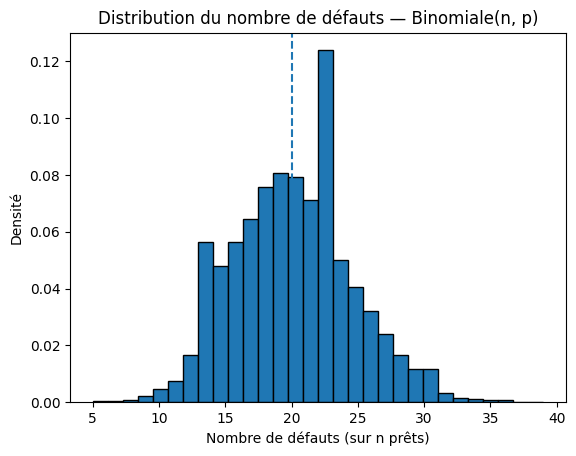


=== Étape 2 : Poisson ===


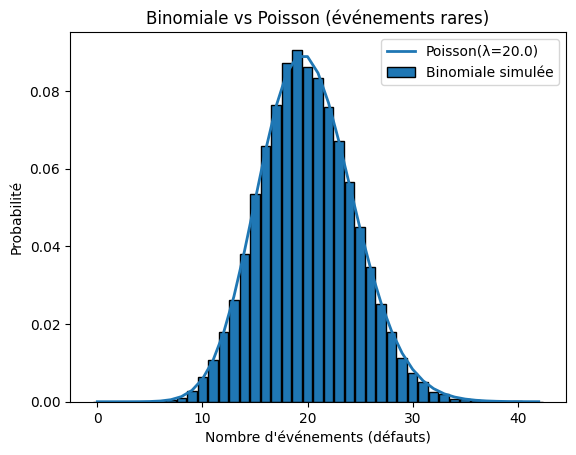

Distance chi-deux (plus petit = mieux): 0.001491

=== Étape 3 : LLN ===


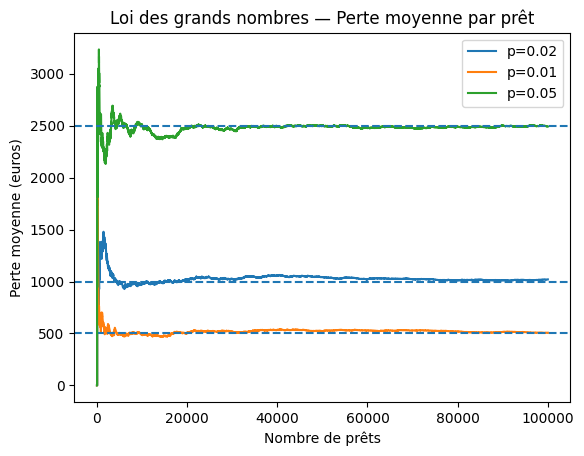


=== Étape 4 : TCL ===


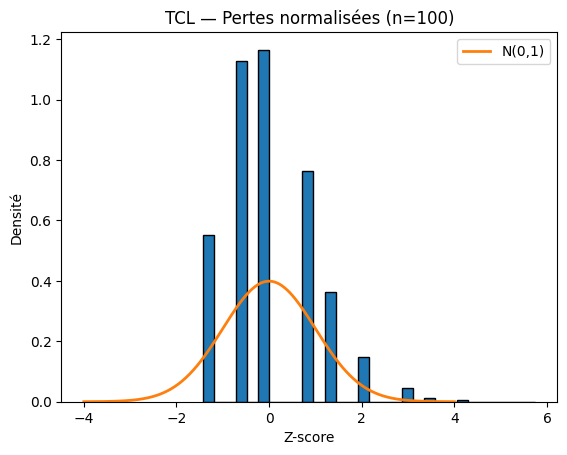

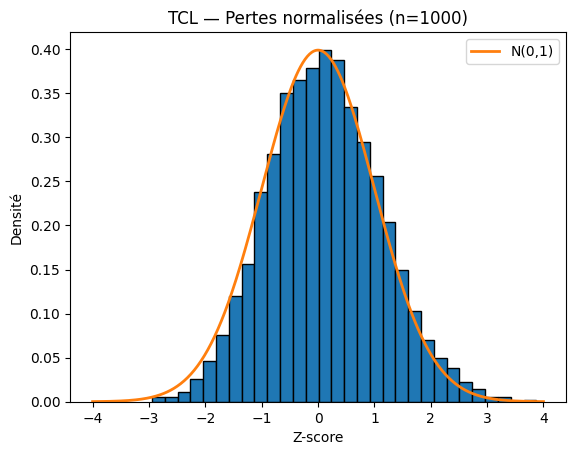

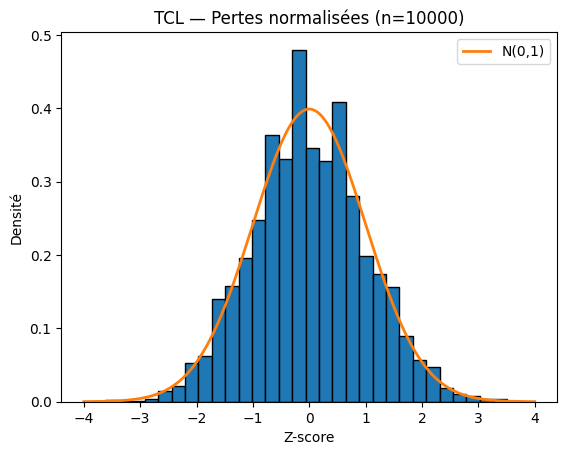


=== Étape 5 : Tests rapides ===
Tous les tests rapides ont passé ✅


In [ ]:
def main():
    print("=== Étape 1 : Binomiale ===")
    n, p, n_sim = 1000, 0.02, 10000
    sample = simulate_defaults(n, p, n_sim)
    print(summarize_defaults(sample, n, p))
    plt.figure()
    plt.hist(sample, bins=30, density=True, edgecolor="black")
    plt.axvline(n * p, linestyle="--")
    plt.title("Distribution du nombre de défauts — Binomiale(n, p)")
    plt.xlabel("Nombre de défauts (sur n prêts)")
    plt.ylabel("Densité")
    plt.show()

    print("\n=== Étape 2 : Poisson ===")
    chi2, xs, emp_probs, pois_pmf = compare_binom_poisson(n=10000, p=0.002, n_sim=30000, show_plot=True)
    print(f"Distance chi-deux (plus petit = mieux): {chi2:.6f}")

    print("\n=== Étape 3 : LLN ===")
    _ = lln_convergence(N=100000, p=0.02, EAD=100000, LGD=0.5, ps_for_sensitivity=[0.01, 0.05], show_plot=True)

    print("\n=== Étape 4 : TCL ===")
    clt_demo(ns=[100, 1000, 10000], p=0.02, EAD=100000, LGD=0.5, n_sim=10000, show_plots=True)

    print("\n=== Étape 5 : Tests rapides ===")
    tests_rapides()
    print("Tous les tests rapides ont passé ✅")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nInterrompu par l'utilisateur.")
        sys.exit(130)